# Does a job training program improve the earnings of disadvantaged workers?

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab
from   scipy import stats

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable for treatment status

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Exercise 1:

#### 1.1

Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?

In [3]:
# cols = list(lalonde_df.columns)
# for col in cols:
#     print("==================================")
#     print(f"Summary statistics for variable: {col}")
#     print(lalonde_df[col].describe())

lalonde_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
lalonde_df["diff_75-74"]=lalonde_df.re75 - lalonde_df.re74
decreased_perc = lalonde_df[lalonde_df["diff_75-74"]<0].shape[0]/lalonde_df.shape[0]*100
print("{:.2f}% of the population experienced a decreased in their income from 1974 to 1975".format(decreased_perc))

46.42% of the population experienced a decreased in their income from 1974 to 1975


**Answer.**

It is clear that the average earnings increased from 1974 to 1976 but they saw a huge decrease in 1975. More precisely, over 46% of the population had a decrease in their earnings that year. After searching a bit about the economy in the US en 1975, we can notice that this coincides with an important recession lived in that decade: https://en.wikipedia.org/wiki/1973%E2%80%931975_recession

We can also see that the unemployement was highest in the US in 1975. This could explain the amount of affected people and the decrease in the average earnings.

---------

#### 1.2 
    
What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?

**Note:** Remember that the *treatment and control groups* correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  `treat` column.

In [6]:
treat_perc = lalonde_df[lalonde_df['treat'] == 1].shape[0]/lalonde_df.shape[0]*100
print("{:.2f}% of the population was in the treatment group".format(treat_perc))

cols = ["re74","re75","re78"]
for col in cols:
    print("==================================")
    treat_median = lalonde_df.loc[lalonde_df['treat'] == 1, col].median()
    control_median = lalonde_df.loc[lalonde_df['treat'] == 0, col].median()
    print(f"The difference in the medians of income for the year 19{col[2:]} (treat-control): {treat_median - control_median}\n")

    treat_mean = lalonde_df.loc[lalonde_df['treat'] == 1, col].mean()
    control_mean = lalonde_df.loc[lalonde_df['treat'] == 0, col].mean()
    print(f"The difference in the means of income for the year 19{col[2:]} (treat-control): {treat_mean - control_mean}\n")

30.13% of the population was in the treatment group
The difference in the medians of income for the year 1974 (treat-control): -2547.047

The difference in the means of income for the year 1974 (treat-control): -3523.6628177382977

The difference in the medians of income for the year 1975 (treat-control): -1086.726

The difference in the means of income for the year 1975 (treat-control): -934.4291293397591

The difference in the medians of income for the year 1978 (treat-control): -743.1959999999999

The difference in the means of income for the year 1978 (treat-control): -635.0262120374209



In [7]:
cols = ["re74","re75","re78"]
for col in cols:
    print("==================================")
    print(f"Checking statistical significant difference in the means of income for the year 19{col[2:]}:")    
    t2, p2 = stats.ttest_ind(lalonde_df.loc[lalonde_df['treat'] == 1, col],lalonde_df.loc[lalonde_df['treat'] == 0, col])
    print("t = " + str(t2))
    print("p = " + str(p2))

Checking statistical significant difference in the means of income for the year 1974:
t = -6.381464485508746
p = 3.464585257757616e-10
Checking statistical significant difference in the means of income for the year 1975:
t = -3.2485513845081773
p = 0.0012234443948498416
Checking statistical significant difference in the means of income for the year 1978:
t = -0.9663522254463778
p = 0.3342496685909654


**Answer.**

We can see that about 30% of the population was in the treatment group. Moreover, the incomes of the control group were higher on average every year. Also, there is not a statistically significant difference betweens the mean income of the population in the control group and the treatment group in 1978 but there is a statistically significant difference in 1974 and 1975. It is very important to note that in this analysis we are not accounting for the impact of the other variables in the data which should be explored further.

---------

#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer.**

It does not necessarily mean that the treatment had a negative impact. By doing the previous analysis, we were not taking into account other factors that are shown in the data such as race, civil status or years of education. We could be witnessing an example of the simpson paradox.

---------

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Exercise 2:

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

In [8]:
def smd(data):
    cols = [col for col in list(data.columns) if col != "treat"]
    smd = dict()
    for col in cols:
        mean_t = data.loc[data.treat == 1, col].mean()
        std_t = data.loc[data.treat == 1, col].std()
        mean_c = data.loc[data.treat == 0, col].mean()
        std_c = data.loc[data.treat == 0, col].std()
        
        smd[col] = abs(mean_t - mean_c)/np.sqrt((std_t**2 + std_c**2)/2)
    
    for k,v in smd.items():
        print("\n==================================")
        print(f"The standarized mean difference (SMD) for {k} is {v}")
        if v < 0.1 : print(f"{k} is balanced")
        elif v <0.2 : print(f"{k} not quite balanced")
        else : print(f"{k} is imbalanced")

    return smd

smd = smd(lalonde_df)


The standarized mean difference (SMD) for age is 0.24190362292609968
age is imbalanced

The standarized mean difference (SMD) for educ is 0.04475508511087086
educ is balanced

The standarized mean difference (SMD) for black is 1.6677188107185172
black is imbalanced

The standarized mean difference (SMD) for hispan is 0.2769395965062943
hispan is imbalanced

The standarized mean difference (SMD) for married is 0.7194919624729043
married is imbalanced

The standarized mean difference (SMD) for nodegree is 0.23504820466514967
nodegree is imbalanced

The standarized mean difference (SMD) for re74 is 0.5957515910049505
re74 is imbalanced

The standarized mean difference (SMD) for re75 is 0.2870021087425329
re75 is imbalanced

The standarized mean difference (SMD) for re78 is 0.0837080938639525
re78 is balanced

The standarized mean difference (SMD) for diff_75-74 is 0.5283059511911306
diff_75-74 is imbalanced


**Answer.**

From the previous analysis we can see how all the features are imbalanced, except for educ (number of education years) and the earnings in 1978.

---------

#### 2.2

Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

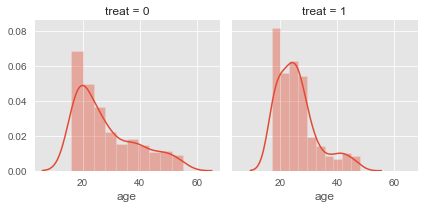

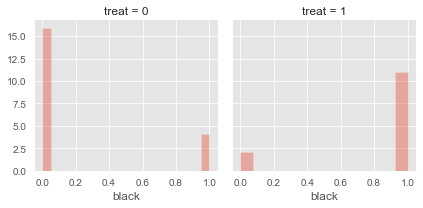

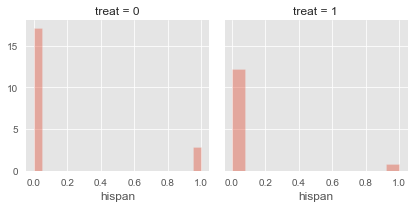

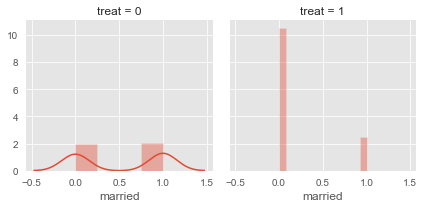

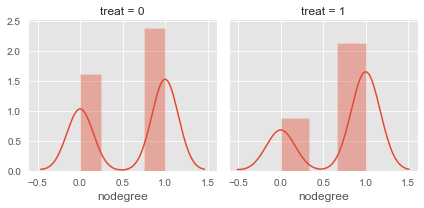

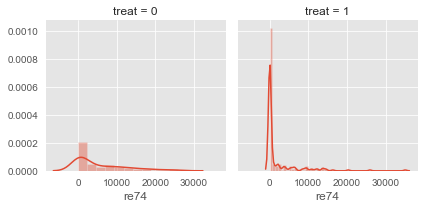

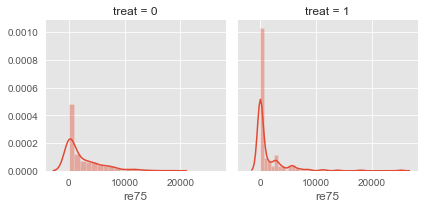

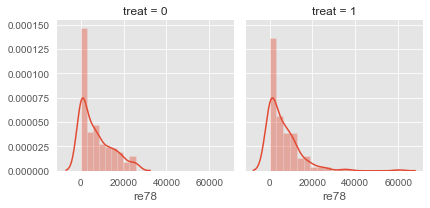

In [9]:
imb_cols = ['age','black','hispan','married','nodegree','re74', 're75', 're78']
for col in imb_cols:
    g = sns.FacetGrid(lalonde_df,col = "treat",margin_titles=True)
    g.map(sns.distplot, col,hist=True)


**Answer.**

## Propensity score matching using logistic regression 

In order to balance the covariates of the control and treatment groups, we will use **matching**. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.
    
In Case 7.5 we used the *Euclidean distance* on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.

We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 3:

#### 3.1 

Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. How would you interpret the predicted values output by the model? 

In [10]:
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,diff_75-74
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.0
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.0
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.0
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.0
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.0


In [11]:
#preprocessing the variables
df_log = pd.concat([lalonde_df.age, lalonde_df.educ, lalonde_df.black, lalonde_df.hispan, \
                  lalonde_df.married, lalonde_df.nodegree, \
                  (lalonde_df.re74 - lalonde_df.re74.mean())/lalonde_df.re74.std(),\
                  (lalonde_df.re75 - lalonde_df.re75.mean())/lalonde_df.re75.std()], axis=1)
df_log["intercept"]=1
df_log.head()

,age,educ,black,hispan,married,nodegree,re74,re75,intercept
NSW1,37,11,1,0,1,1,-0.703546,-0.662971,1
NSW2,22,9,0,1,0,1,-0.703546,-0.662971,1
NSW3,30,12,1,0,0,0,-0.703546,-0.662971,1
NSW4,27,11,1,0,0,1,-0.703546,-0.662971,1
NSW5,33,8,1,0,0,1,-0.703546,-0.662971,1


In [12]:
log_reg_model = sm.Logit(lalonde_df.treat, df_log)
log_reg1 = log_reg_model.fit()
log_reg1.summary()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 16 Jul 2020   Pseudo R-squ.:                  0.3508
Time:                        22:22:43   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.013       0.034       0.289
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74          -0.4650      0.186     -2.497      0.013      -0.830      -0.100
re75           0.1761      0.153      1.153      0.249      -0.123       0.476
intercept     -4.9390      1.026     -4.815      0.000      -6.950      -2.928
==============================================================================
"""

**Answer.**

From the model, we can see that age, education, race, degree and earnings in 1975 are positively correlated with the defining if a person should receive treatment or not.

In particular, we see that the fact that a person is hispanic increases the odds of being in the control group by ~98%, and being black by ~306%. Also, having a degree increases the odds by ~70%. The age does not have a very high p-value and the coefficients is quite low compared to others. Each education year, nonetheless, increases the odds by 16%. 

We can also notice how the marital status and the earnings in 1974 impact negatively the odds of a person receiving treatment.

From this, it is also noticeable how the fact of being married decreases the odds of being in the treatment group by ~83%.

In the normalized scale of earnings, an increase in 1 std of the earnings of 1974 decreases the odds by 46% while an increase in 1 std of the earnings of 1975 increases the odds by 17%.

It is also noticeable that the intercept is quite low (~ -5) which is compensating for the big effects of other coefficients.

We must also highlight that the p-value of re74 and age is much higher than 0.05 and these relations are not statistically significant as we have them in our model.

---------

#### 3.2

Use `.predict()`  to obtain the propensity scores of individuals in our dataset. Save the the results with the name `pscore_logit` (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.

In [13]:
pscore_logit = log_reg1.predict(df_log)
pscore_df = df_log.copy()
pscore_df["pscore"] = pscore_logit
pscore_df["treat"] = lalonde_df.treat
pscore_df.head()

# log_reg_model.exog_names

,age,educ,black,hispan,married,nodegree,re74,re75,intercept,pscore,treat
NSW1,37,11,1,0,1,1,-0.703546,-0.662971,1,0.638770,1
NSW2,22,9,0,1,0,1,-0.703546,-0.662971,1,0.224634,1
NSW3,30,12,1,0,0,0,-0.703546,-0.662971,1,0.678244,1
NSW4,27,11,1,0,0,1,-0.703546,-0.662971,1,0.776324,1
NSW5,33,8,1,0,0,1,-0.703546,-0.662971,1,0.701639,1


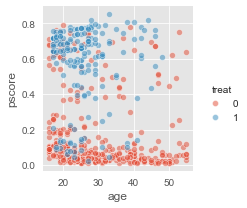

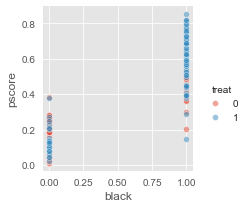

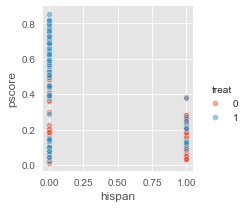

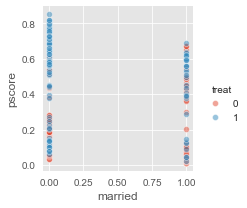

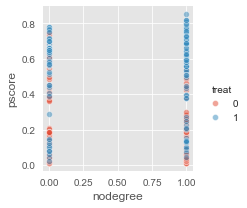

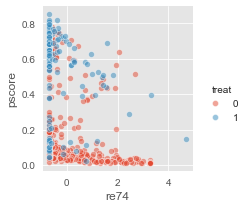

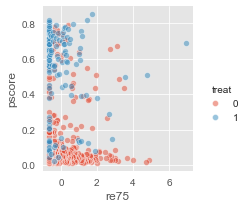

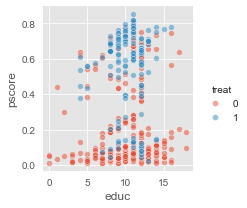

In [14]:
cols = ['age','black','hispan','married','nodegree','re74', 're75', 'educ']
for col in cols:
    g = sns.FacetGrid(pscore_df ,margin_titles=True,hue = "treat")
    g.map(sns.scatterplot, col, "pscore",alpha = 0.5)
    g.add_legend()

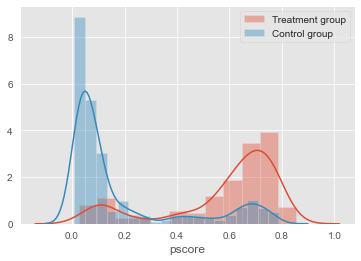

In [15]:
sns.distplot(pscore_df[pscore_df.treat==1].pscore,kde = True, label = "Treatment group")
sns.distplot(pscore_df[pscore_df.treat==0].pscore,kde = True, label = "Control group")
plt.legend()
plt.show()

**Answer.**

In the last histogram, we can clearly see that there is not a match between the propensity scores of the control and treatment groups.

We can also see in the previous scatter plots how this is reflected in the pscore against each of the other variables.

---------

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Exercise 4:

In this exercise, we will use the `sklearn.neighbors` function [`NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.

#### 4.1

Separate the propensity scores `pscore_logit` found in Exercise 3 for treatment and control groups. Call these `treat_pscores` and `control_pscores` respectively. Use the `control_pscores` to train a $k$-NN algorithm with $k=5$.

**Hint:** Load the model using `knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')`. You may want to reshape the control scores using `control_pscores.reshape(-1,1)`.

In [16]:
control_pscores = pscore_df[pscore_df.treat==0].pscore
treat_pscores = pscore_df[pscore_df.treat==1].pscore
knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')

knn.fit(np.array(control_pscores).reshape(-1,1))

NearestNeighbors(metric='euclidean')

**Answer.**

---------

#### 4.2

Find the indices of the five nearest neighbors using the method `.kneighbors()` applied to `treat_pscores`. 

In [17]:
nearest_treat_5 = knn.kneighbors(np.array(treat_pscores).reshape(-1,1))

**Answer.**

---------

#### 4.3

Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of `DataFrames`, each with $185$ rows from the `lalonde_df`. The first should correspond to the treatment group and the second should correspond to the matched control group.

In [18]:
#nearest neighbor indexes of the control group to the treat group
nearest_treat = nearest_treat_5[1][:,0]

#dataframe with the treatment group
treat_df = pscore_df[pscore_df.treat==1]
treat_df["re78"] = lalonde_df.re78

#getting control group
control_df = pscore_df[pscore_df.treat==0]
control_df["re78"] = lalonde_df.re78

#using the nearest neighbor indexes to obtain the control group that is closer to the treatment group
control_df_nearest = control_df.iloc[nearest_treat]

control_df_nearest

,age,educ,black,hispan,married,nodegree,re74,re75,intercept,pscore,treat,re78
PSID69,30,17,1,0,0,0,2.048456,1.019966,1,0.638554,0,14421.1300
PSID111,51,11,0,0,0,1,-0.695985,0.494116,1,0.224079,0,1525.0140
PSID370,16,9,1,0,0,1,-0.703546,-0.662971,1,0.678789,0,2158.9590
PSID226,39,10,1,0,0,1,-0.573190,-0.392984,1,0.778912,0,701.9201
PSID140,19,9,1,0,0,1,-0.536896,0.208919,1,0.705085,0,14344.2900
...,...,...,...,...,...,...,...,...,...,...,...,...
PSID239,18,11,0,1,0,1,-0.703546,-0.471752,1,0.279756,0,0.0000
PSID76,26,12,0,1,0,0,0.526522,0.887417,1,0.154729,0,4181.9660
PSID380,34,12,1,0,1,0,-0.703546,-0.662971,1,0.494177,0,18716.8800
PSID24,47,8,1,0,1,1,0.728257,1.929339,1,0.508688,0,0.0000


**Answer.**

---------

### Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.

### Exercise 5:

Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.

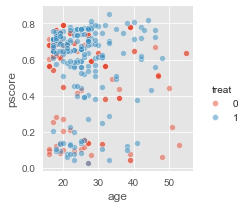

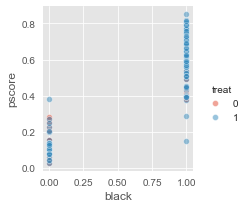

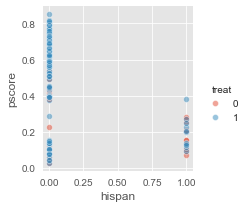

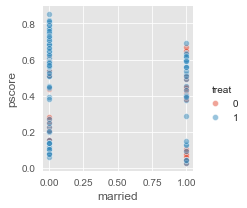

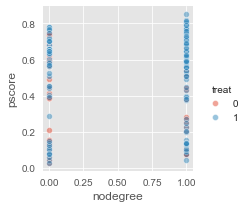

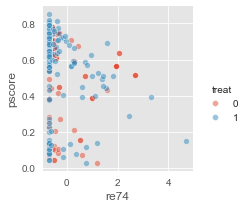

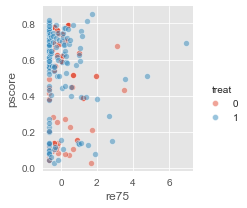

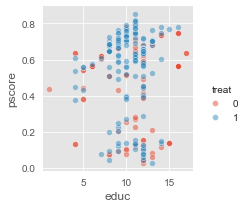

In [19]:
matched_df = control_df_nearest.append(treat_df)

cols = ['age','black','hispan','married','nodegree','re74', 're75', 'educ']
for col in cols:
    g = sns.FacetGrid(matched_df ,margin_titles=True,hue = "treat")
    g.map(sns.scatterplot, col, "pscore",alpha = 0.5)
    g.add_legend()

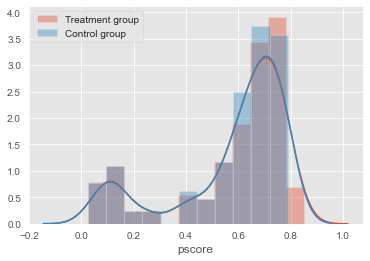

In [20]:
sns.distplot(matched_df[matched_df.treat==1].pscore,kde = True, label = "Treatment group")
sns.distplot(matched_df[matched_df.treat==0].pscore,kde = True, label = "Control group")
plt.legend()
plt.show()

**Answer.**

In the previous histogram of the propensity score we can see how both distributions match very well, showing a correct matching of the control and treatment groups.

Moreover, the pscore scatter plots reflect how both groups are closer in each variable.

---------

### Exercise 6:

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

In [22]:
# Use this to delete the column with the differences in earnings between re75 and re74
lalonde_df.drop("diff_75-74",axis=1,inplace=True)

In [70]:
def asmd(data_after_match, data_before_match):
    cols = [col for col in list(data_before_match.columns) if col not in ["treat","re78"]]
    smd = dict()
    for col in cols:
        mean_t = data_after_match.loc[data_after_match.treat == 1, col].mean()
        std_t = data_before_match.loc[data_before_match.treat == 1, col].std()
        mean_c = data_after_match.loc[data_after_match.treat == 0, col].mean()
        std_c = data_before_match.loc[data_before_match.treat == 0, col].std()
        
        smd[col] = abs(mean_t - mean_c)/np.sqrt((std_t**2 + std_c**2)/2)
    
    for k,v in smd.items():
        print("\n==================================")
        print(f"The standarized mean difference after matching (ASMD) for {k} is {v}")
        if v < 0.1 : print(f"{k} is balanced")
        elif v <0.2 : print(f"{k} not quite balanced")
        else : print(f"{k} is imbalanced")

    return smd

logit_asmd = asmd(matched_df,lalonde_df)


The standarized mean difference after matching (ASMD) for age is 0.1872126802863005
age not quite balanced

The standarized mean difference after matching (ASMD) for educ is 0.013134145374003385
educ is balanced

The standarized mean difference after matching (ASMD) for black is 0.014075653068095993
black is balanced

The standarized mean difference after matching (ASMD) for hispan is 0.018094286765336625
hispan is balanced

The standarized mean difference after matching (ASMD) for married is 0.13218931558924027
married not quite balanced

The standarized mean difference after matching (ASMD) for nodegree is 0.0114080416111945
nodegree is balanced

The standarized mean difference after matching (ASMD) for re74 is 6.28708922125025e-06
re74 is balanced

The standarized mean difference after matching (ASMD) for re75 is 2.6212428114506304e-06
re75 is balanced


**Answer.**

We can see that after matching, we obtained a balance in most of the covariates. We only achieved an ASMD between 0.1 and 0.2 for "age" and "married" covariates. Nevertheless, this is acceptable.

Therefore, we can now use these results to compare the earnings of the control and treatment group in 1978 to obtain a more accurate comparison of both groups.

---------

### Exercise 7:

Estimate the average effect of treatment on <font color='red'> wages (`re78`) </font> after matching. What do you conclude?

In [71]:
treat_df["treat_effect"] = treat_df.re78.values - control_df_nearest.re78.values
treat_df.treat_effect.mean()

1774.4613708108106

**Answer.**

We can see that, on average, the treatment group earned 1770 usd more than the control group in 1978.

---------

## Propensity score matching using decision trees and random forests

### Exercise 8:

To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.

#### 8.1

Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. Use the `sklearn.tree` function `DecisionTreeRegressor(max_depth=4)` and call the new propensity scores `pscore_tree`.

In [25]:
dtr = tree.DecisionTreeRegressor(max_depth = 4)

covariates = [col for col in list(lalonde_df.columns) if col not in ["treat","re78"]]
dtr = dtr.fit(lalonde_df[covariates],lalonde_df.treat)
pscore_tree = dtr.predict(lalonde_df[covariates])

In [37]:
pscore_tree

array([0.86458333, 0.5       , 0.86458333, 0.86458333, 0.86458333,
       0.86458333, 0.86458333, 0.86458333, 0.86458333, 0.08333333,
       0.62222222, 0.86458333, 0.62222222, 0.86458333, 0.62222222,
       0.62222222, 0.86458333, 0.86458333, 0.86458333, 0.86458333,
       0.86458333, 0.5       , 0.5       , 0.86458333, 0.62222222,
       0.86458333, 0.86458333, 0.5       , 0.62222222, 0.86458333,
       0.62222222, 0.86458333, 0.86458333, 0.62222222, 0.86458333,
       0.86458333, 0.86458333, 0.86458333, 0.86458333, 0.86458333,
       0.86458333, 0.5       , 0.62222222, 0.25      , 0.62222222,
       0.86458333, 0.62222222, 0.62222222, 0.86458333, 0.86458333,
       0.86458333, 0.86458333, 0.62222222, 0.86458333, 0.86458333,
       0.62222222, 0.86458333, 0.86458333, 0.86458333, 0.5       ,
       0.62222222, 0.86458333, 0.86458333, 0.86458333, 0.86458333,
       0.86458333, 0.86458333, 0.5       , 0.86458333, 0.86458333,
       0.86458333, 0.86458333, 0.62222222, 0.86458333, 0.86458

**Answer.**

---------

#### 8.2

Plot the decision tree regressor using the code

```
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')
```

Replace `dt` with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)

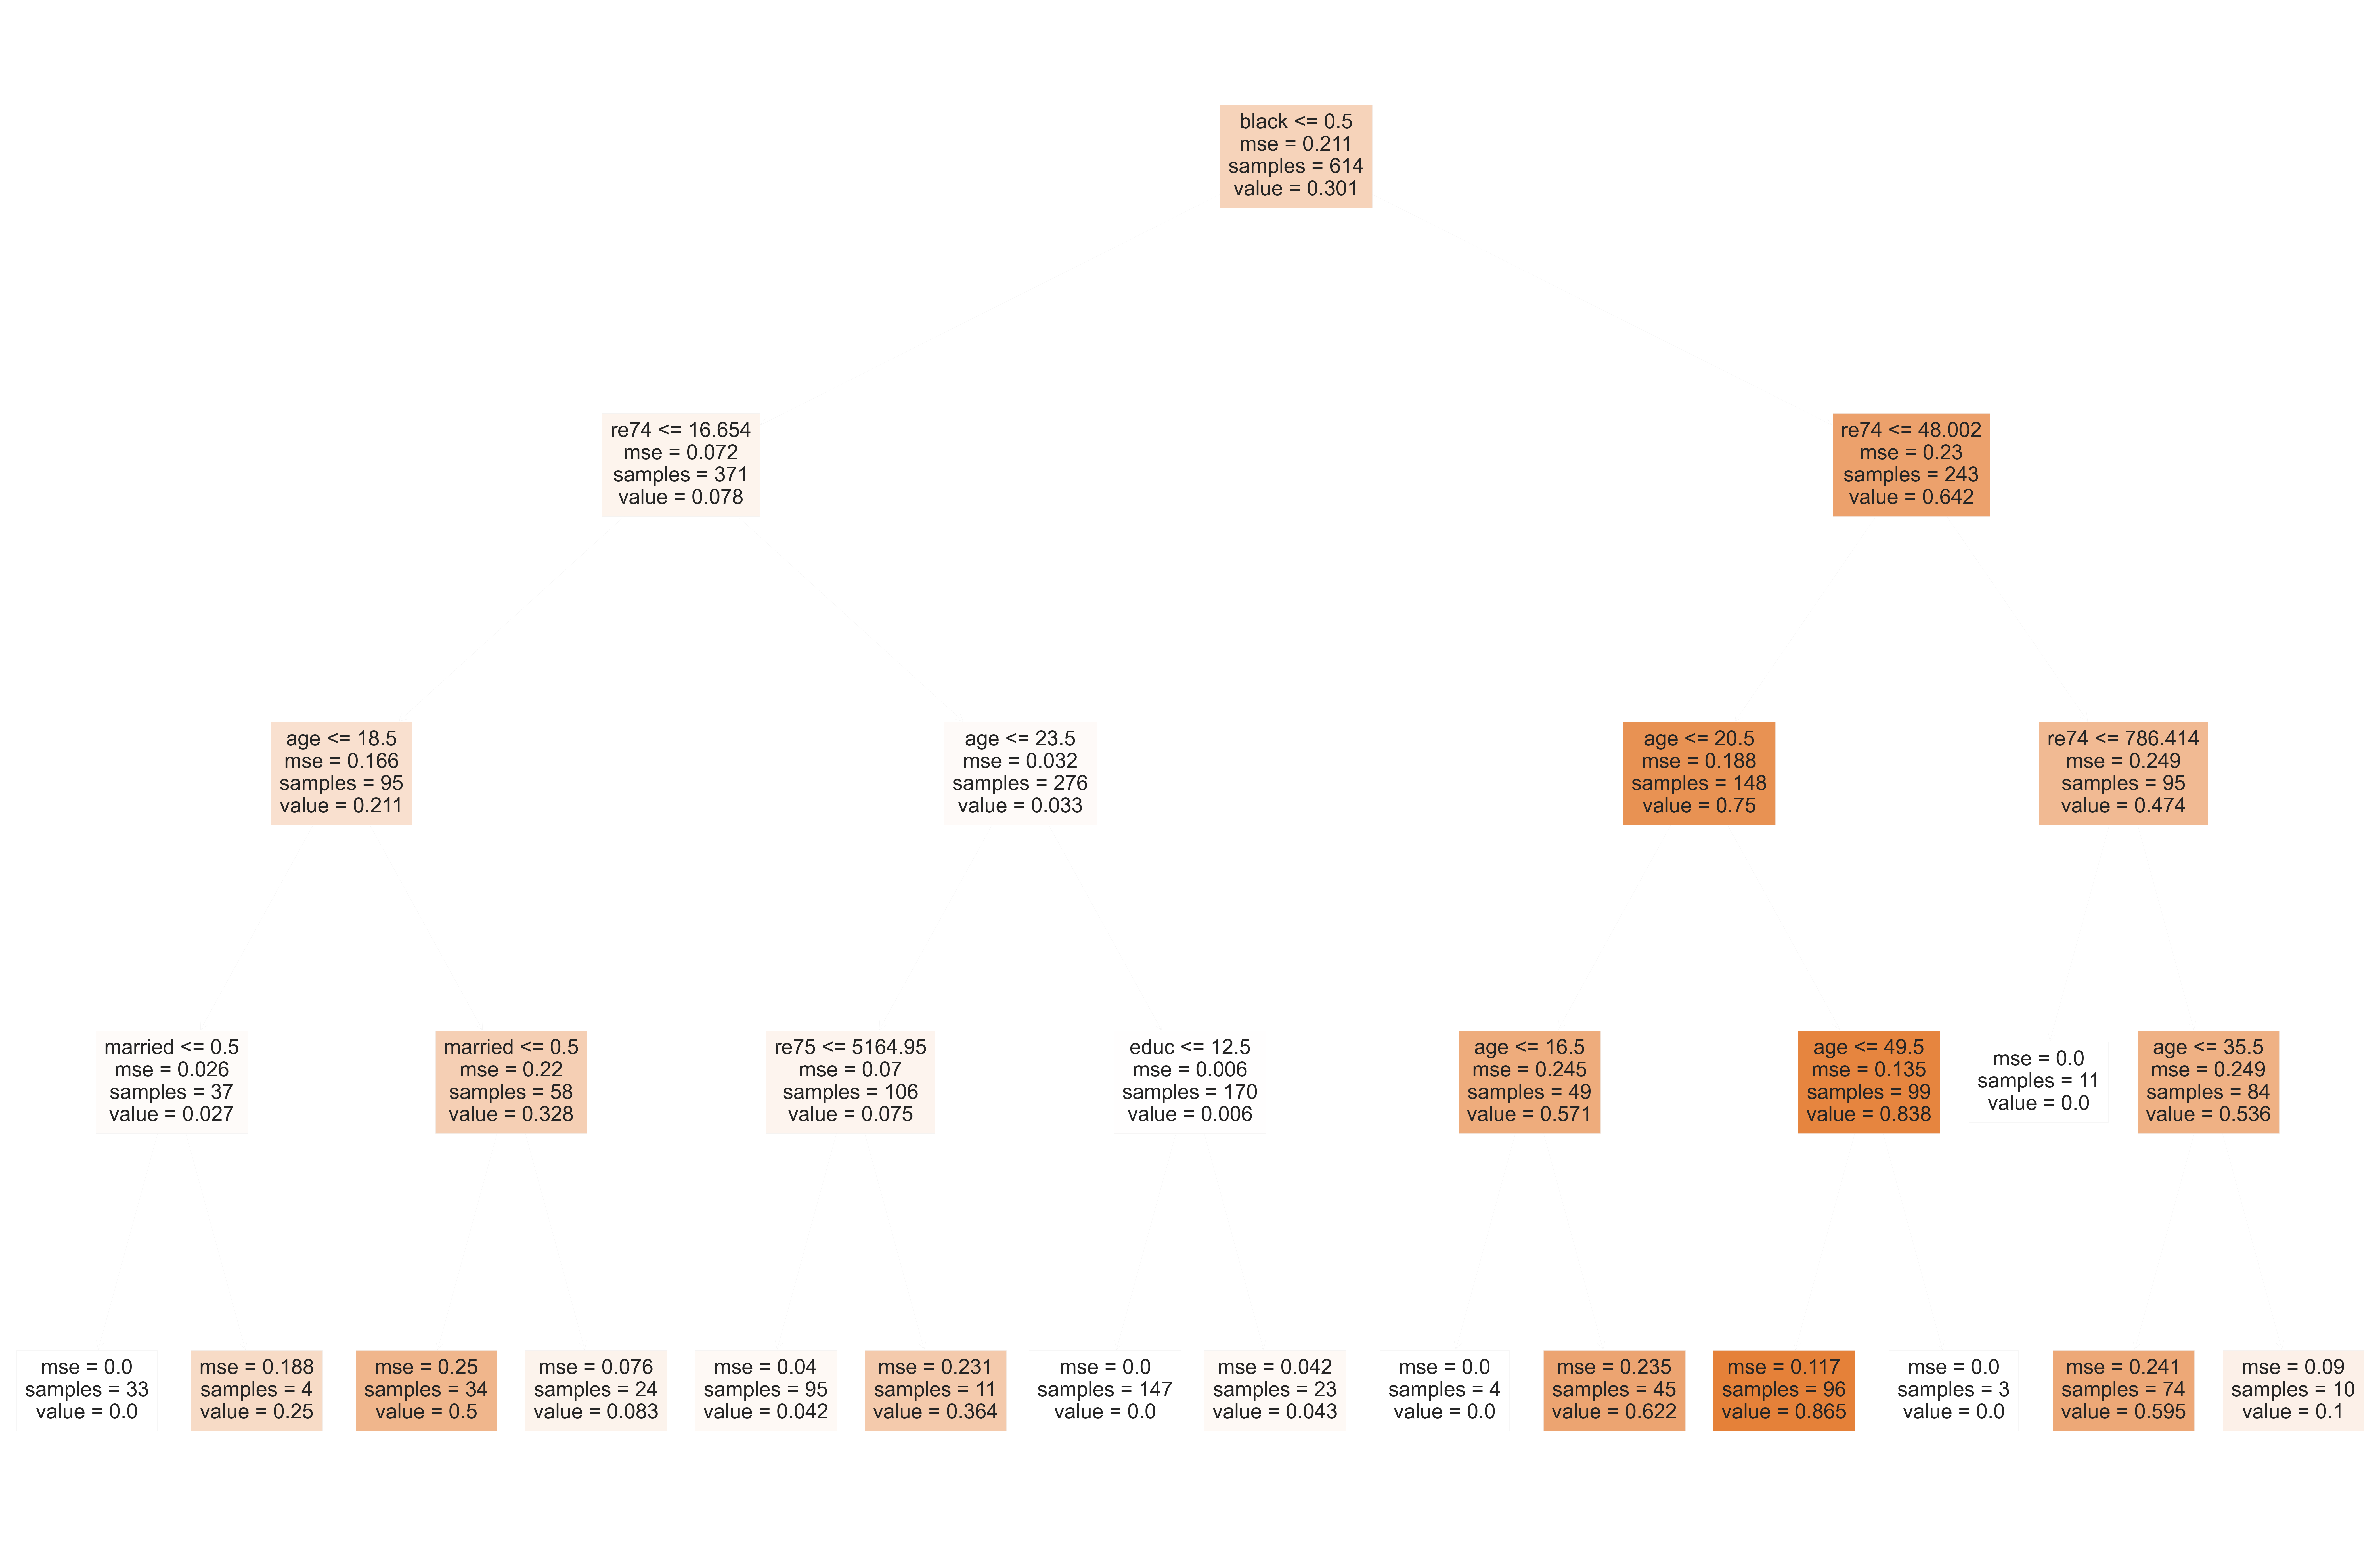

In [26]:
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dtr,filled=True,feature_names=covariates)
fig.savefig('tree.png')

**Answer.**

**Probability that a 24 year old, single, uneducated Hispanic individual that earned  \$20000  in 1974 was enrolled in the employment program:**

Left->Right->Right->Left: We obtain a 0.0\% probability for the subject to be enrolled in the employement program.

**Probability that a 24 year old, single, uneducated Black individual that earned  \$20000  in 1974 was enrolled in the employment program:**

Right->Left->Right->Left: We obtain a 86.5\% probability for the subject to be enrolled in the employement program.

---------

#### 8.3

Estimate the propensity scores now by using random forests. For the model, use the `sklearn.ensemble` function `RandomForestClassifier` with parameters `n_estimators=100, max_depth=4, random_state=42`. Then, use the method `predict_proba` to extract the propensity scores. Name the scores `pscore_forest`.

In [29]:
rfc = ensemble.RandomForestClassifier(n_estimators=100,max_depth=4,random_state=42)
rfc.fit(lalonde_df[covariates],lalonde_df.treat)
pscore_forest = rfc.predict_proba(lalonde_df[covariates])

In [34]:
pscore_forest

array([[0.36670829, 0.63329171],
       [0.61015369, 0.38984631],
       [0.26464797, 0.73535203],
       ...,
       [0.75290709, 0.24709291],
       [0.40824479, 0.59175521],
       [0.81436528, 0.18563472]])

**Answer.**

---------

#### 8.4

Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model *seems* to do the best job?

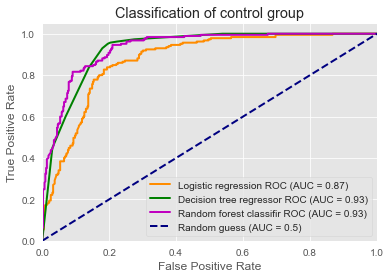

In [57]:
roc_logit = metrics.roc_curve(lalonde_df.treat,pscore_logit)
roc_dtr = metrics.roc_curve(lalonde_df.treat,pscore_tree)
roc_rfc = metrics.roc_curve(lalonde_df.treat,pscore_forest[:,1])

auc_logit = metrics.auc(roc_logit[0],roc_logit[1])
auc_dtr = metrics.auc(roc_dtr[0],roc_dtr[1])
auc_rfc = metrics.auc(roc_rfc[0],roc_rfc[1])

plt.figure()
line_width = 2

plt.plot(roc_logit[0],roc_logit[1], color='darkorange', lw=line_width,
         label=f"Logistic regression ROC (AUC = {auc_logit:0.2f})")

plt.plot(roc_dtr[0],roc_dtr[1], color='g', lw=line_width,
         label=f"Decision tree regressor ROC (AUC = {auc_dtr:0.2f})")

plt.plot(roc_rfc[0],roc_rfc[1], color='m', lw=line_width,
         label=f"Random forest classifir ROC (AUC = {auc_rfc:0.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of control group')
plt.legend(loc='lower right')
plt.show()

In [59]:
# pscore_logit
# pscore_tree
# pscore_forest[:,1]

print("AUC for logistic regression: ",auc_logit)
print("AUC for decision tree: ",auc_dtr)
print("AUC for random forest: ",auc_rfc)

AUC for logistic regression:  0.8742266742266742
AUC for decision tree:  0.9260379260379261
AUC for random forest:  0.9325206325206326


**Answer.**
From the ROC curves and the AUC values, it would seem that decision tree and random forest perform the best, with the random forest performing slightly better.


---------

#### 8.5

Consider the following statement:

>  "*A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.*"

Is the statement true or false? Explain. 

**Answer.**

In general, **a better AUC does mean that the model better predicts the true propensity scores, at least for the given dataset**. Nevertheless, the application of the model is very important in the selection of the model.

A first consideration is also that a higher AUC could also mean overfitting of the data. This could imply that the model would wrongly assign pscores to a validation dataset and, therefore, wrongly balance the covariates.

For example, we know that decision trees are quite variable, even with the same dataset. If such a model was selected only due to its AUC-score and intended to predict the pscore of an independent validation dataset, it might have a lower performance than a logistic regression. This could also be extended to the random forest, which has a lower variance due to its random nature but still might underperform on independent datasets. This, in turn, would imply that the model is not as good balancing covariates as expected.

---------

#### 8.6

Repeat the matching procedure now with the estimated propensity scores `pscore_tree` and `pscore_forest`. Assess the covariate balances and estimate the average effect of treatment on wages (`re78`) after matching. Compare your results. 

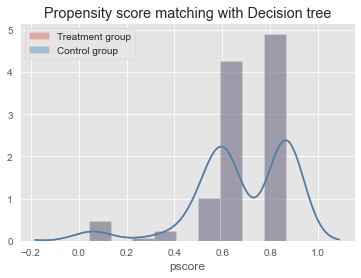


The standarized mean difference after matching (ASMD) for age is 0.03897803438137481
age is balanced

The standarized mean difference after matching (ASMD) for educ is 0.6698414140741611
educ is imbalanced

The standarized mean difference after matching (ASMD) for black is 0.0
black is balanced

The standarized mean difference after matching (ASMD) for hispan is 0.12666000735735639
hispan not quite balanced

The standarized mean difference after matching (ASMD) for married is 0.3725335257514953
married is imbalanced

The standarized mean difference after matching (ASMD) for nodegree is 1.0837639530634886
nodegree is imbalanced

The standarized mean difference after matching (ASMD) for re74 is 3.106837866766331e-05
re74 is balanced

The standarized mean difference after matching (ASMD) for re75 is 0.00010516878664524633
re75 is balanced

Using Decision Trees: the mean difference between wages in 1978 of the treat and control group is 
      4184.6494762162165 USD


In [84]:
#Matching using the prediction of the decision tree-----------------------

pscore_df_dt = df_log.copy()
pscore_df_dt["pscore"] = pscore_tree
pscore_df_dt["treat"] = lalonde_df.treat

control_pscores_dt = pscore_df_dt[pscore_df_dt.treat==0].pscore
treat_pscores_dt = pscore_df_dt[pscore_df_dt.treat==1].pscore
knn = neighbors.NearestNeighbors(n_neighbors=10,metric='euclidean')

knn.fit(np.array(control_pscores_dt).reshape(-1,1))

nearest_treat_10_dt = knn.kneighbors(np.array(treat_pscores_dt).reshape(-1,1))

#nearest neighbor indexes of the control group to the treat group
nearest_treat_dt = nearest_treat_10_dt[1][:,0]

#dataframe with the treatment group
treat_df_dt = pscore_df_dt[pscore_df_dt.treat==1]
treat_df_dt["re78"] = lalonde_df.re78

#getting control group
control_df_dt = pscore_df_dt[pscore_df_dt.treat==0]
control_df_dt["re78"] = lalonde_df.re78

#using the nearest neighbor indexes to obtain the control group that is closer to the treatment group
control_df_nearest_dt = control_df_dt.iloc[nearest_treat_dt]

control_df_nearest_dt
matched_df_dt = control_df_nearest_dt.append(treat_df_dt)

sns.distplot(matched_df_dt[matched_df_dt.treat==1].pscore,kde = True, label = "Treatment group")
sns.distplot(matched_df_dt[matched_df_dt.treat==0].pscore,kde = True, label = "Control group")
plt.legend()
plt.title('Propensity score matching with Decision tree')
plt.show()

dt_asmd = asmd(matched_df_dt,lalonde_df)

treat_df_dt["treat_effect"] = treat_df_dt.re78.values - control_df_nearest_dt.re78.values
print(f"""\nUsing Decision Trees: the mean difference between wages in 1978 of the treat and control group is 
      {treat_df_dt.treat_effect.mean()} USD""")

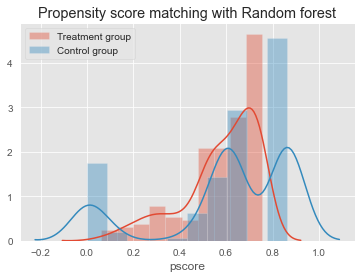


The standarized mean difference after matching (ASMD) for age is 0.12047756081515895
age not quite balanced

The standarized mean difference after matching (ASMD) for educ is 0.05253658149601282
educ is balanced

The standarized mean difference after matching (ASMD) for black is 0.1548321837490542
black not quite balanced

The standarized mean difference after matching (ASMD) for hispan is 0.10856572059201976
hispan not quite balanced

The standarized mean difference after matching (ASMD) for married is 0.10815489457301476
married not quite balanced

The standarized mean difference after matching (ASMD) for nodegree is 0.13689649933433543
nodegree not quite balanced

The standarized mean difference after matching (ASMD) for re74 is 1.9110595615567922e-05
re74 is balanced

The standarized mean difference after matching (ASMD) for re75 is 6.336891666413593e-05
re75 is balanced

Using Random forest: the mean difference between wages in 1978 of the treat and control group is 
      929.61

In [79]:
#Matching using the prediction of the random forest-----------------------

pscore_df_rf = df_log.copy()
pscore_df_rf["pscore"] = pscore_forest[:,1]
pscore_df_rf["treat"] = lalonde_df.treat

control_pscores_rf = pscore_df_rf[pscore_df_rf.treat==0].pscore
treat_pscores_rf = pscore_df_rf[pscore_df_rf.treat==1].pscore
knn = neighbors.NearestNeighbors(n_neighbors=10,metric='euclidean')

knn.fit(np.array(control_pscores_rf).reshape(-1,1))

nearest_treat_10_rf = knn.kneighbors(np.array(treat_pscores_rf).reshape(-1,1))

#nearest neighbor indexes of the control group to the treat group
nearest_treat_rf = nearest_treat_10_rf[1][:,0]

#dataframe with the treatment group
treat_df_rf = pscore_df_rf[pscore_df_rf.treat==1]
treat_df_rf["re78"] = lalonde_df.re78

#getting control group
control_df_rf = pscore_df_dt[pscore_df_rf.treat==0]
control_df_rf["re78"] = lalonde_df.re78

#using the nearest neighbor indexes to obtain the control group that is closer to the treatment group
control_df_nearest_rf = control_df_rf.iloc[nearest_treat_rf]

control_df_nearest_rf
matched_df_rf = control_df_nearest_rf.append(treat_df_rf)

sns.distplot(matched_df_rf[matched_df_rf.treat==1].pscore,kde = True, label = "Treatment group")
sns.distplot(matched_df_rf[matched_df_rf.treat==0].pscore,kde = True, label = "Control group")
plt.legend()
plt.title('Propensity score matching with Random forest')
plt.show()

rf_asmd = asmd(matched_df_rf,lalonde_df)

treat_df_rf["treat_effect"] = treat_df_rf.re78.values - control_df_nearest_rf.re78.values
print(f"""\nUsing Random forest: the mean difference between wages in 1978 of the treat and control group is 
      {treat_df_rf.treat_effect.mean()} USD""")

**Answer.**

We can see that:

**Decision tree** could balance "age", "black", "re74" and "re75", could not balance "educ", "married" and "nodegree". The rest of covariates remained in a not-quite-balanced state.

Moreover, the pscore histogram showed a visually perfect superposition of the control and treatment group.

Finally, after the matching, the estimated average difference in wage during 1978 between the treat and matched control group is approximately 4185 USD. Despite an apparently perfect matching of the pscore, there is not a very good balance of the model. It is also suspicious that we have such a perfect match in the histogram.

On the other hand:

**Random forest** did a good job balancing "age","re74" and "re75", while the rest remained in a not-quite-balanced state.

The pscore histogram showed a superposition but not a very similar shape of the pscore distributions between the treat and control group.

The estimated average difference in wage during 1978, which was approximately 929 USD. 

We can also notice that the logistic regression seems to perform in the middle of the random forest and the decision tree.

---------

#### 8.7

Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  

**Hint:** Look at the distances of the ten nearest neighbors output by `.kneighbors()` for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?

In [95]:
print(f"The max distance fitted was {nearest_treat_10_dt[0].max()}")
print(f"Decision tree is estimating a distance of 0 for {(nearest_treat_10_dt[0] == 0).sum()} subjects")

The max distance fitted was 0.11363636363636365
Decision tree is estimating a distance of 0 for 1830 subjects


**Answer.**

We know that the decision tree chooses one covariate in a given node and chooses it in a way that it classifies better than all the other covariates. Also, it chooses the threshold of each particular covariate based on the exact data provided in the dataset, meaning that it does not create a threshold in based on the trend of the data as the logistic regression does, for example. 

Moreover, the "variety" of propensity scores that the tree can provide are given by the depth of the tree itself. As we can see in the tree plot only 15 leaf nodes and not all of the pscores are different among them. Therefore, many subjects are expected to be fitted with the exact same value of propensity score. Then, the nearest neighbor will not be defined as the truly nearest neighbor but as the first subject that falls within that leaf node which, in turn, depends on the order the algorithm itself chooses.

We can see from the calculation above that 1830 subjects are assigned a distance of 0 with their closest neighbor. Due to this, we are probably not choosing the correct subjects to balance the control group which, in turn, results in a bad performance of the covariates balance process and, therefore, a low reliability of the matching and estimation of the program impact.

---------